###Importing libraries & models

In [1]:
!pip install keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.5/129.5 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 11.4 MB/s eta 0:00:00


In [2]:
# Import libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import keras_tuner
from keras.applications import ResNet50, VGG16
from keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split

import pickle

# Print the version of tensorflow and keras
print("TensorFlow version:{}".format(tf.__version__))

Using TensorFlow backend
TensorFlow version:2.14.0


###Importing & Preprocessing images for testing

In [3]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

170498071/170498071 [==============================] - 4s 0us/step


In [4]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=12)

In [5]:
# Helper function to preprocess the image so that it can be inputted in ResNet50
def preprocess(image):
  image = tf.keras.applications.resnet50.preprocess_input(image)
 #image = image[None, ...]
  return image

x_train = preprocess(x_train)
x_val = preprocess(x_val)
x_test = preprocess(x_test)

In [ ]:
%%script false --no-raise-error
import gc
del x_train
del x_val
del y_train
del y_val
gc.collect()

267

## Models tuning

In [6]:
model_rs50 = tf.keras.applications.ResNet50(include_top=False, weights='imagenet', input_shape=(32,32,3))
model_rs50.trainable = False
model_vgg16 = tf.keras.applications.VGG16(include_top=False, weights='imagenet', input_shape=(32,32,3))
model_vgg16.trainable = False

94765736/94765736 [==============================] - 1s 0us/step


58889256/58889256 [==============================] - 1s 0us/step


In [8]:
def print_images_test(images: list, titles: list, rows=1, columns=3) -> None:
    assert len(images) == len(titles), "'images' and 'titles' must be of the same length"
    assert len(images) == (columns*rows), "The number of images and rows*columns must match"
    fig = plt.figure(figsize=(15, 15))
    # ax enables access to manipulate each of subplots
    ax = []

    for i in range(columns*rows):
        img = images[i]
        # create subplot and append to ax
        ax.append( fig.add_subplot(rows, columns, i+1) )
        ax[-1].set_title(titles[i])  # set title
        plt.imshow(img)

    plt.show()  # finally, render the plot

In [11]:
def build_model_resnet(hp):
    hp_n_neurons_1 = hp.Choice(name="n_neurons_1", values=[512, 1024, 1536], default=1024)
    hp_n_neurons_2 = hp.Choice(name="n_neurons_2", values=[64, 128], default=64)
    hp_dropout_rate_1 = hp.Choice(name="dropout_rate_1", values=[0.05, 0.1, 0.15, 0.2], default=0.05)
    hp_dropout_rate_2 = hp.Choice(name="dropout_rate_2", values=[0.05, 0.1, 0.15, 0.2], default=0.05)
    hp_act_fun_1 = hp.Choice(name="act_fun_1", values=["relu", "tanh"], default="relu")
    hp_act_fun_2 = hp.Choice(name="act_fun_2", values=["relu", "tanh"], default="relu")
    hp_learning_rate = hp.Choice(name="learning_rate", values=[1e-3, 5e-4, 1e-4], default=1e-3)

    model = tf.keras.Sequential()
    model.add(model_rs50)
    model.add(tf.keras.layers.GlobalAveragePooling2D())
    model.add(tf.keras.layers.Dense(hp_n_neurons_1, activation=hp_act_fun_1))
    model.add(tf.keras.layers.Dropout(hp_dropout_rate_1))
    model.add(tf.keras.layers.Dense(hp_n_neurons_2, activation=hp_act_fun_2))
    model.add(tf.keras.layers.Dropout(hp_dropout_rate_2))
    model.add(tf.keras.layers.Dense(10, activation='softmax'))
    model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(), optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate), metrics=['accuracy'])
    return model

def build_model_vgg16(hp):
    hp_n_neurons_1 = hp.Choice(name="n_neurons_1", values=[1024, 2048], default=1024)
    hp_n_neurons_2 = hp.Choice(name="n_neurons_2", values=[256, 512, 1024], default=512)
    hp_n_neurons_3 = hp.Choice(name="n_neurons_3", values=[64, 128, 192], default=128)
    hp_dropout_rate_1 = hp.Choice(name="dropout_rate_1", values=[0.05, 0.1, 0.15, 0.2], default=0.05)
    hp_dropout_rate_2 = hp.Choice(name="dropout_rate_2", values=[0.05, 0.1, 0.15, 0.2], default=0.05)
    hp_dropout_rate_3 = hp.Choice(name="dropout_rate_3", values=[0.05, 0.1, 0.15, 0.2], default=0.05)
    hp_act_fun_1 = hp.Choice(name="act_fun_1", values=["relu", "tanh"], default="relu")
    hp_act_fun_2 = hp.Choice(name="act_fun_2", values=["relu", "tanh"], default="relu")
    hp_act_fun_3 = hp.Choice(name="act_fun_3", values=["relu", "tanh"], default="relu")
    hp_learning_rate = hp.Choice(name="learning_rate", values=[1e-3, 5e-4, 1e-4], default=1e-3)

    model = tf.keras.Sequential()
    model.add(model_vgg16)
    model.add(tf.keras.layers.GlobalAveragePooling2D())
    model.add(tf.keras.layers.Dense(hp_n_neurons_1, activation=hp_act_fun_1))
    model.add(tf.keras.layers.Dropout(hp_dropout_rate_1))
    model.add(tf.keras.layers.Dense(hp_n_neurons_2, activation=hp_act_fun_2))
    model.add(tf.keras.layers.Dropout(hp_dropout_rate_2))
    model.add(tf.keras.layers.Dense(hp_n_neurons_3, activation=hp_act_fun_3))
    model.add(tf.keras.layers.Dropout(hp_dropout_rate_3))
    model.add(tf.keras.layers.Dense(10, activation='softmax'))
    model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(), optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate), metrics=['accuracy'])
    return model

def tune_model(model_builder, val_data, train_data):
    images_train, labels_train = train_data
    images_val, labels_val = val_data
    tuner = keras_tuner.BayesianOptimization(
        model_builder,
        objective='val_accuracy',
        max_trials=15,
        overwrite=True)
    tuner.search(images_train, labels_train, epochs=5, validation_data=(images_val, labels_val))
    return tuner.get_best_hyperparameters()[0].values

In [12]:
tune_model(model_builder=build_model_resnet, val_data=(x_val, y_val), train_data=(x_train, y_train))

Trial 15 Complete [00h 02m 27s]
val_accuracy: 0.6787999868392944

Best val_accuracy So Far: 0.6794999837875366
Total elapsed time: 00h 33m 57s


{'n_neurons_1': 1024,
 'n_neurons_2': 128,
 'dropout_rate_1': 0.2,
 'dropout_rate_2': 0.05,
 'act_fun_1': 'relu',
 'act_fun_2': 'tanh',
 'learning_rate': 0.0001}

In [14]:
tune_model(model_builder=build_model_vgg16, val_data=(x_val, y_val), train_data=(x_train, y_train))

Trial 15 Complete [00h 01m 25s]
val_accuracy: 0.6506999731063843

Best val_accuracy So Far: 0.6726999878883362
Total elapsed time: 00h 21m 30s


{'n_neurons_1': 1024,
 'n_neurons_2': 256,
 'n_neurons_3': 64,
 'dropout_rate_1': 0.2,
 'dropout_rate_2': 0.2,
 'dropout_rate_3': 0.05,
 'act_fun_1': 'relu',
 'act_fun_2': 'relu',
 'act_fun_3': 'relu',
 'learning_rate': 0.001}

## ResNet50 model

Model idea by [kutaykutlu](https://www.kaggle.com/code/kutaykutlu/resnet50-transfer-learning-cifar-10-beginner)

In [15]:
model_resnet = tf.keras.Sequential()
model_resnet.add(model_rs50)
model_resnet.add(tf.keras.layers.GlobalAveragePooling2D())
model_resnet.add(tf.keras.layers.Dense(1024, activation='relu'))
model_resnet.add(tf.keras.layers.Dropout(0.2))
model_resnet.add(tf.keras.layers.Dense(128, activation='relu'))
model_resnet.add(tf.keras.layers.Dropout(0.15))
model_resnet.add(tf.keras.layers.Dense(10, activation='softmax'))

model_resnet.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(), optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), metrics=['accuracy'])

early_stopping = EarlyStopping(monitor="val_loss", patience=7, verbose=2, restore_best_weights=False)

history = model_resnet.fit(x=x_train, y=y_train, epochs=10, batch_size=128, verbose=1, validation_data=(x_val,y_val))

Epoch 1/10
313/313 - 13s - loss: 1.3523 - accuracy: 0.5505 - val_loss: 1.0664 - val_accuracy: 0.6306 - 13s/epoch - 42ms/step
Epoch 2/10
313/313 - 8s - loss: 1.0294 - accuracy: 0.6416 - val_loss: 0.9982 - val_accuracy: 0.6478 - 8s/epoch - 25ms/step
Epoch 3/10
313/313 - 7s - loss: 0.9104 - accuracy: 0.6809 - val_loss: 0.9679 - val_accuracy: 0.6621 - 7s/epoch - 21ms/step
Epoch 4/10
313/313 - 7s - loss: 0.8166 - accuracy: 0.7130 - val_loss: 0.9639 - val_accuracy: 0.6698 - 7s/epoch - 22ms/step
Epoch 5/10
313/313 - 8s - loss: 0.7326 - accuracy: 0.7408 - val_loss: 0.9736 - val_accuracy: 0.6714 - 8s/epoch - 25ms/step
Epoch 6/10
313/313 - 7s - loss: 0.6525 - accuracy: 0.7655 - val_loss: 0.9901 - val_accuracy: 0.6747 - 7s/epoch - 22ms/step
Epoch 7/10
313/313 - 8s - loss: 0.5869 - accuracy: 0.7876 - val_loss: 1.0366 - val_accuracy: 0.6748 - 8s/epoch - 25ms/step
Epoch 8/10
313/313 - 6s - loss: 0.5141 - accuracy: 0.8155 - val_loss: 1.0509 - val_accuracy: 0.6784 - 6s/epoch - 21ms/step
Epoch 9/10
313

In [16]:
test_loss, test_accuracy = model_resnet.evaluate(x_test, y_test)
print(f"Test loss: {test_loss}, Test accuracy: {test_accuracy}")

313/313 [==============================] - 4s 12ms/step - loss: 1.2117 - accuracy: 0.6683
Test loss: 1.2116906642913818, Test accuracy: 0.6682999730110168


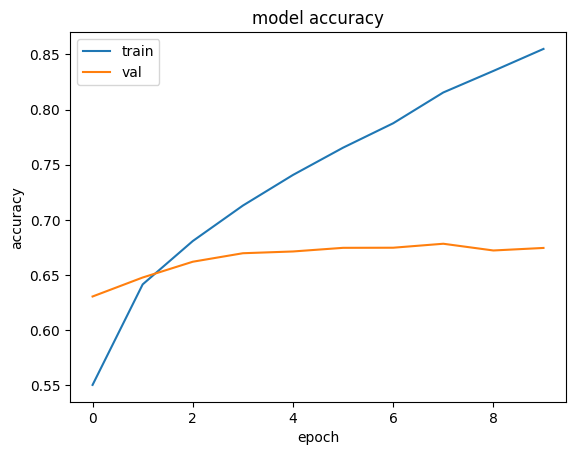

In [17]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [18]:
model_resnet.save("opa_model_resnet50.keras")

## VGG16 model

In [19]:
model_vgg = tf.keras.Sequential()
model_vgg.add(model_vgg16)
model_vgg.add(tf.keras.layers.GlobalAveragePooling2D())
model_vgg.add(tf.keras.layers.Dense(1024, activation='relu'))
model_vgg.add(tf.keras.layers.Dropout(0.05))
model_vgg.add(tf.keras.layers.Dense(512, activation='relu'))
model_vgg.add(tf.keras.layers.Dropout(0.05))
model_vgg.add(tf.keras.layers.Dense(64, activation='relu'))
model_vgg.add(tf.keras.layers.Dropout(0.05))
model_vgg.add(tf.keras.layers.Dense(10, activation='softmax'))

model_vgg.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(), optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), metrics=['accuracy'])

early_stopping = EarlyStopping(monitor="val_loss", patience=5, verbose=2, restore_best_weights=False)

history = model_vgg.fit(x=x_train, y=y_train, epochs=10, batch_size=128, verbose=1, validation_data=(x_val,y_val))

Epoch 1/10
313/313 [==============================] - 11s 25ms/step - loss: 1.7364 - accuracy: 0.4795 - val_loss: 1.1218 - val_accuracy: 0.6177
Epoch 2/10
313/313 [==============================] - 7s 23ms/step - loss: 1.0457 - accuracy: 0.6391 - val_loss: 1.0234 - val_accuracy: 0.6560
Epoch 3/10
313/313 [==============================] - 7s 22ms/step - loss: 0.8800 - accuracy: 0.6928 - val_loss: 1.0115 - val_accuracy: 0.6601
Epoch 4/10
313/313 [==============================] - 7s 23ms/step - loss: 0.7530 - accuracy: 0.7355 - val_loss: 1.0008 - val_accuracy: 0.6695
Epoch 5/10
313/313 [==============================] - 7s 22ms/step - loss: 0.6448 - accuracy: 0.7730 - val_loss: 1.0432 - val_accuracy: 0.6634
Epoch 6/10
313/313 [==============================] - 7s 23ms/step - loss: 0.5590 - accuracy: 0.8016 - val_loss: 1.0701 - val_accuracy: 0.6734
Epoch 7/10
313/313 [==============================] - 8s 26ms/step - loss: 0.4810 - accuracy: 0.8285 - val_loss: 1.1741 - val_accuracy: 0.660

In [20]:
test_loss, test_accuracy = model_vgg.evaluate(x_test, y_test)
print(f"Test loss: {test_loss}, Test accuracy: {test_accuracy}")

313/313 [==============================] - 3s 9ms/step - loss: 1.4536 - accuracy: 0.6563
Test loss: 1.4536124467849731, Test accuracy: 0.6563000082969666


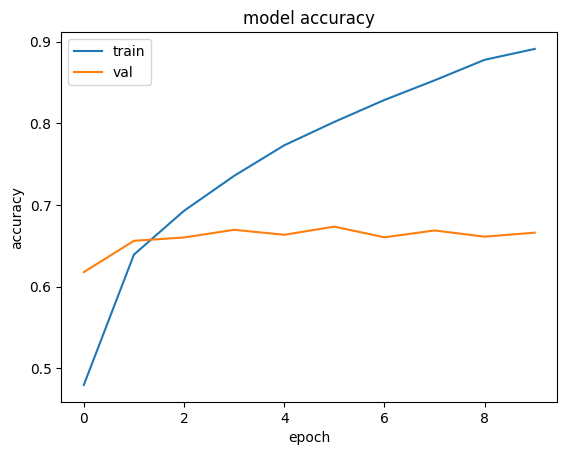

In [21]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [22]:
model_vgg.save("opa_model_vgg16.keras")